# Saving and loading model

There are multiple ways how to save a trained model.

You can either:
* Save whole model including weights and architecture either using hdf5 file or SavedModel
* Save only the network structure
* Save only the weights

In [ ]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Dense, Input, Flatten, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.datasets import fashion_mnist
import random
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Loss

## Setup simple NN for testing

Load and process the car data.

In [ ]:
URL = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
COLUMN_NAMES = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']

dataset = pd.read_csv(
    URL,
    names=COLUMN_NAMES,
    na_values='?',
    sep=' ',
    comment='\t',
    skipinitialspace=True)

In [ ]:
dataset = dataset.dropna()

In [ ]:
train_dataset = dataset.sample(frac = 0.8, random_state = 42)
test_dataset = dataset.drop(train_dataset.index)

In [ ]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [ ]:
def standardize(data):
    return (data-data.mean())/data.std()

In [ ]:
train_features = standardize(train_dataset)
test_features = standardize(test_dataset)

## Neural network without custom code

Setup the simple network without custom parts.

In [ ]:
input_layer = Input(shape=(7,))
x = Dense(32, activation='relu', name='FC_1')(input_layer)
x = Dense(32, activation='relu', name='FC_2')(x)
output_layer = Dense(1, name='FC_out')(x)
model = Model(inputs = input_layer, outputs = output_layer)

In [ ]:
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam())

In [ ]:
%%time
history = model.fit(
    train_features,
    train_labels,
    batch_size = 16,
    validation_split=0.2,
    verbose=1, 
    epochs=700)

## Saving to HDF5 (or h5) format

Saves everything to HDF https://en.wikipedia.org/wiki/Hierarchical_Data_Format hieratic format.

Everything is saved to one file that is easy to work on.

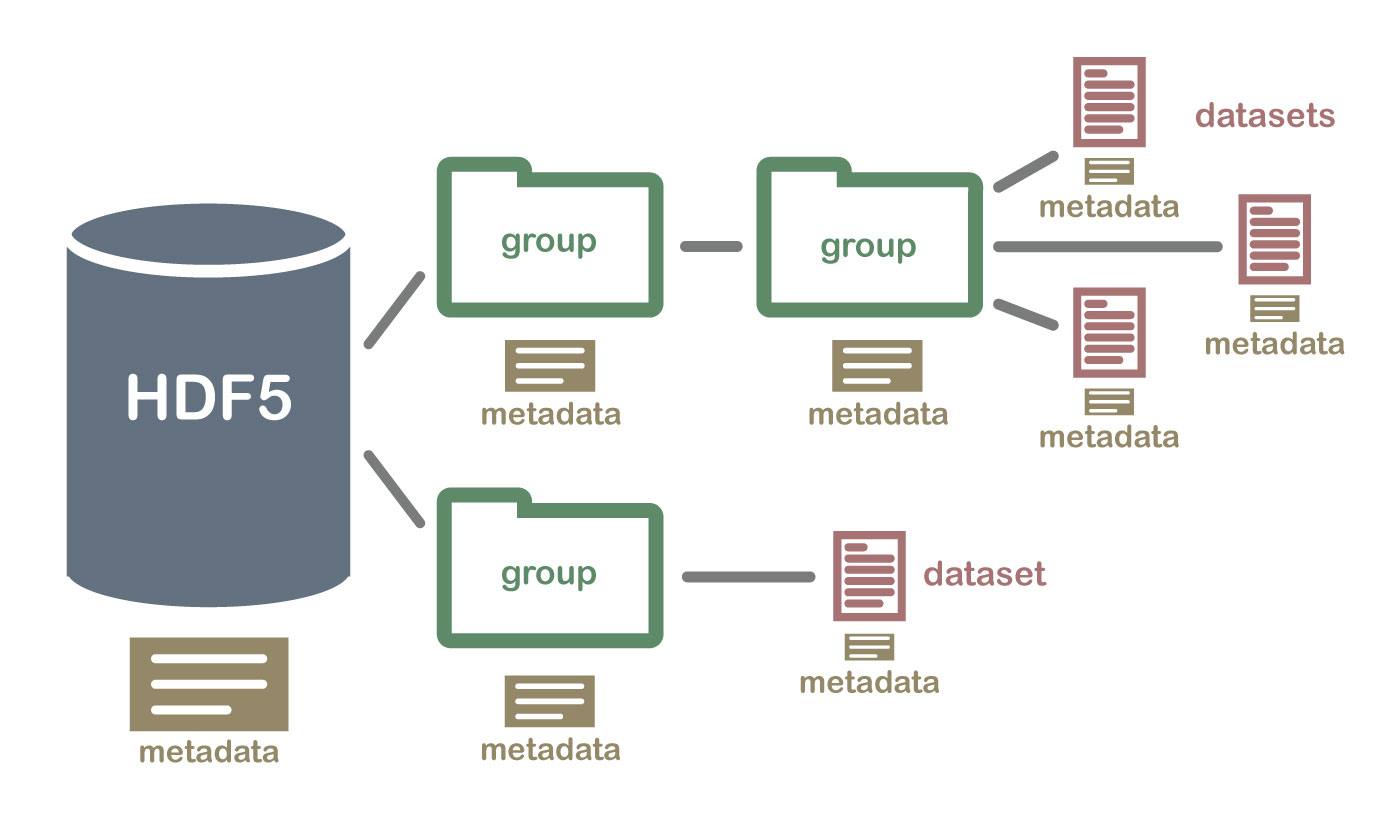

https://www.neonscience.org/resources/learning-hub/tutorials/about-hdf5

**Disadvantages:**

*  has troubles to deal with custom objects

In [ ]:
# it does not matter if you save the file as *.h5 or *.hdf5
model.save('trained_hdf.h5')

## Load hdf5

Loading model is as simple as calling load_model

In [ ]:
model_hdf = keras.models.load_model('trained_hdf.h5')

In [ ]:
model_hdf.evaluate(test_features, test_labels, verbose=0)

In [ ]:
model.evaluate(test_features, test_labels, verbose=0)

## SavedModel

Newer and more capable format for saving models.

It saves not only model structure and model weights, but also graphs of call functions, so it can better deal with custom objects.

Disadvantage could be in the fact that models are saved in multiple files in directory, so it is little bit more cumbersome to use.

In [ ]:
# saved model is used when you are calling save without *.h5 or *.hdf5 in file name
model.save('trained_saved_model')

In [ ]:
model_saved_model = keras.models.load_model('trained_saved_model')

In [ ]:
model.evaluate(test_features, test_labels, verbose=0)

In [ ]:
model_saved_model.evaluate(test_features, test_labels, verbose=0)

## Dealing with custom objects

### Custom models 

As I pointed out, HDF5 will not work with custom models.

In [ ]:
# the same architecture as before, just encapsulated in a custom model
class CustomModel(Model):
    def __init__(self, units=32, activation='relu', **kwargs):
        '''initializes the instance attributes'''
        super().__init__(**kwargs)
        self.hidden1 = Dense(units, activation=activation, name='FC_1')
        self.hidden2 = Dense(units, activation=activation, name='FC_2')
        self.main_output = Dense(1)

    def call(self, inputs):
        hidden1 = self.hidden1(inputs)
        hidden2 = self.hidden2(hidden1)
        cur_output = self.main_output(hidden2)        
        return cur_output

In [ ]:
model = CustomModel(units = 32)
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam())

In [ ]:
%%time
history = model.fit(
    train_features,
    train_labels,
    batch_size = 16,
    validation_split=0.2,
    verbose=1, 
    epochs=700)

SavedModel format does not need any modification to operate.

In [ ]:
model.save('custom_model')

In [ ]:
custom_model = keras.models.load_model('custom_model')

In [ ]:
custom_model.evaluate(test_features, test_labels)

In [ ]:
model.evaluate(test_features, test_labels)

However trying to save into hdf format raises error.

You would need to specify in custom model how exactly needs to be model serialized.

In [ ]:
model.save('custom_model.h5')

### Custom layers/loss

Working with contrastive loss on fashion mninst.

Download and preprocess data.

In [ ]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [ ]:
train_images = train_images / 255.0
test_images = test_images / 255.0

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [ ]:
def sort_labels_by_classes(labels):
    result = []
    for i in range(len(class_names)):
        #  np.where returns the indices of elements in an input array where the given condition is satisfied
        result.append(np.where(labels == i)[0])
    return result

In [ ]:
train_classes = sort_labels_by_classes(train_labels)
test_classes = sort_labels_by_classes(test_labels)

In [ ]:
def create_pairs(data, labels):
    pairs_data = []
    pairs_labels = []
    class_count = len(class_names)
    # go per each of cloth class
    for i in range(len(labels)):
        # class for processing
        class_label_length = len(labels[i])
        # go for each of item in current cloth class
        for j in range(class_label_length-1):
            # get the positive pair - n and n+1 item from current label
            idx1, idx2 = labels[i][j], labels[i][j + 1]
            # save to list and set label to 1
            pairs_data.append([data[idx1], data[idx2]])
            pairs_labels.append(1.0)

            # random generate increment from 1-9 to add to current class index
            increment = random.randrange(1, class_count)
            # add increment to class index and apply modulo by class count to get random negative class label index
            negative_label_index = (i + increment) % class_count
            # take random item from other label items to create a negative pair
            negative_sample = random.choice(labels[negative_label_index])
            # save negative pair and set label to 0
            pairs_data.append([data[idx1], data[negative_sample]])
            pairs_labels.append(0.0)
    # numpy arrays are easier to work with, so type list into it
    return np.array(pairs_data), np.array(pairs_labels)

In [ ]:
X_train, Y_train = create_pairs(train_images, train_classes)
X_test, Y_test = create_pairs(test_images, test_classes)

Set up Siamese network.

In [ ]:
def initialize_base_network():
    input = Input(shape=(28,28,))
    x = Flatten()(input)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    return Model(inputs=input, outputs=x)

Use custom layer instead of Lambda layer.

In [ ]:
class EuclideanDistanceLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, vects):
        x, y = vects
        sum_square = tf.reduce_sum(tf.square(tf.subtract(x, y)), axis=1, keepdims=True)
        return tf.sqrt(tf.maximum(sum_square, K.epsilon()))

In [ ]:
def get_model():
    base_network = initialize_base_network()
    # create the left input and point to the base network
    input_a = Input(shape=(28,28,), name="left_input")
    vect_output_a = base_network(input_a)

    # create the right input and point to the base network
    input_b = Input(shape=(28,28,), name="right_input")
    vect_output_b = base_network(input_b)

    # measure the similarity of the two vector outputs
    output = EuclideanDistanceLayer()([vect_output_a, vect_output_b])

    # specify the inputs and output of the model
    model = Model([input_a, input_b], output)

    return model

In [ ]:
# margin is a parametr settable by developer
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        '''Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        '''
        square_pred = tf.square(y_pred)
        margin_square = tf.square(tf.maximum(margin - y_pred, 0))
        return (y_true * square_pred + (1 - y_true) * margin_square)    
    return contrastive_loss

In [ ]:
model = get_model()
model.compile(loss=contrastive_loss_with_margin(margin=0.5), optimizer=Adam())
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
%%time
history = model.fit([X_train[:,0], X_train[:,1]], Y_train, batch_size=128, verbose=1, epochs=5)

#### Saving model to h5

In [ ]:
model.save('trained_siamese.h5')

#### Loading model from h5
Simple load will not work, you need to specify custom objects Keras does not know.

In [ ]:
loaded_model_hdf = keras.models.load_model('trained_siamese.h5')

If we would like to load including custom loss, you need to specify hyperparameter, since Keras did not save this information.

In [ ]:
loaded_model_hdf = keras.models.load_model(
    'trained_siamese.h5', 
    custom_objects={'EuclideanDistanceLayer': EuclideanDistanceLayer,
                    # h5 does not save custom hyperparameter, you need to specify it during loading
                    'contrastive_loss': contrastive_loss_with_margin(0.5)
                   })

If you want to save the loss with the hyperparameter, you would need to create loss function by inheriting 

```
tensorflow.keras.losses.Loss
```

You need to set *get_config* function to set up serialization.

In [ ]:
class Contrastive_loss_with_margin(Loss):  
    # set threshold in constructor
    def __init__(self, margin, **kwargs):
        super().__init__(**kwargs)
        self.margin = margin

    def call(self, y_true, y_pred):
        square_pred = tf.square(y_pred)
        margin_square = tf.square(tf.maximum(self.margin - y_pred, 0))
        return (y_true * square_pred + (1 - y_true) * margin_square) 
    
    # set how to serialiaze margin
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, 'margin': self.margin}

In [ ]:
model = get_model()
model.compile(loss=Contrastive_loss_with_margin(margin=0.5), optimizer=Adam())
history = model.fit([X_train[:,0], X_train[:,1]], Y_train, batch_size=128, verbose=1, epochs=5)
model.save('trained_siamese.h5')

loaded_model_hdf = keras.models.load_model(
    'trained_siamese.h5',
    custom_objects={'EuclideanDistanceLayer': EuclideanDistanceLayer,
                    'Contrastive_loss_with_margin': Contrastive_loss_with_margin})

#### Saving model in SavedModel format
Using SavedModel format you only need to specify custom loss.

In [ ]:
model.save('trained_siamese')

In [ ]:
load_model_saved_model = keras.models.load_model('trained_siamese', custom_objects={'Contrastive_loss_with_margin': Contrastive_loss_with_margin})

### Loading just for prediction

But in a case if you want to use model just for predictions, you can just load model withou compiling

In [ ]:
model_for_predictions = keras.models.load_model('trained_siamese', compile=False)

In [ ]:
model_for_predictions.predict([X_test[:,0], X_test[:,1]])

### Dealing with Lambda layers

Lambda layer code is not saved in any type of file.

If you do not want to wrap functionality to special type of layer, you could just save the weights and load them to the initialized model.

In [ ]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.reduce_sum(tf.square(tf.subtract(x, y)), axis=1, keepdims=True)
    return tf.sqrt(tf.maximum(sum_square, K.epsilon()))

In [ ]:
def get_model_with_lambda():
    base_network = initialize_base_network()

    # create the left input and point to the base network
    input_a = Input(shape=(28,28,), name="left_input")
    vect_output_a = base_network(input_a)

    # create the right input and point to the base network
    input_b = Input(shape=(28,28,), name="right_input")
    vect_output_b = base_network(input_b)

    # measure the similarity of the two vector outputs
    output = Lambda(euclidean_distance, name="output_layer")([vect_output_a, vect_output_b])

    # specify the inputs and output of the model
    model = Model([input_a, input_b], output)
    
    return model

In [ ]:
%%time
model = get_model_with_lambda()
model.compile(loss=Contrastive_loss_with_margin(margin=0.5), optimizer=Adam())
history = model.fit([X_train[:,0], X_train[:,1]], Y_train, batch_size=128, verbose=1, epochs=5)

#### Save model weights to h5

You can save just weights of the model, without architecture.

In [ ]:
model.save_weights('contrastive_model_weights.h5')

Create new untrained model.

In [ ]:
new_model = get_model_with_lambda()

In [ ]:
new_model.predict([X_test[:,0], X_test[:,1]])

#### Load weights from file

In [ ]:
new_model.load_weights('contrastive_model_weights.h5')

In [ ]:
new_model.predict([X_test[:,0], X_test[:,1]])

In [ ]:
model.predict([X_test[:,0], X_test[:,1]])